In [18]:
# import os
# os.environ['USE_PYGEOS']
import geopandas as gpd
from pathlib import Path
import numpy as np
import warnings
from tqdm.notebook import tqdm
import datetime
import os
import hvplot.xarray

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

In [19]:
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
# river_network_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg.geojson')
# river_network_pts_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset>
Dimensions:    (index: 9)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 8
Data variables:
    x          (index) object '-88.21874800000001' ... '-85.944131'
    y          (index) object '37.018747' '36.959995' ... '35.801042' '36.29222'
    name       (index) object 'Barkley_Dam' 'Laurel_Dam' ... 'Cordell_Hull_Dam'
    id         (index) int64 0 1 2 3 4 5 6 7 8
    elevation  (index) float64 106.0 301.0 196.0 195.0 ... 201.0 268.0 158.0
    geometry   (index) object POINT (-88.218748 37.018747) ... POINT (-85.944...

{0: Text(0.5173537645425763, -0.9199158658987252, '0'),
 1: Text(-0.5059282967696115, 1.0, '1'),
 2: Text(-0.23851806587297708, 0.4422573426278435, '2'),
 3: Text(0.35210105696528543, 0.2387261256735405, '3'),
 4: Text(0.37580737828921995, -0.41305640946380895, '4'),
 5: Text(0.9436655831317095, -0.8108669937817355, '5'),
 6: Text(-0.48874005554327454, 0.03968813281323473, '6'),
 7: Text(-0.9895391274011566, 0.5139943500317963, '7'),
 8: Text(0.0337977626582285, -0.0908266820021451, '8')}

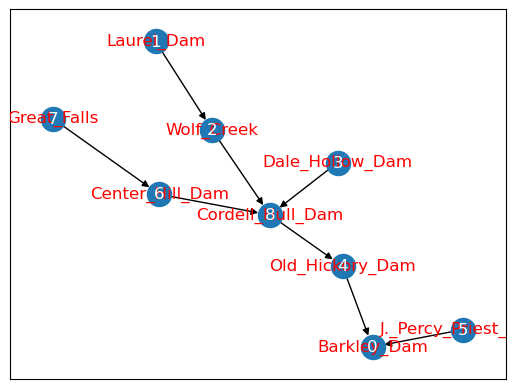

In [20]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [21]:
list(nx.topological_sort(G)) # upstream most is first element

[1, 3, 5, 7, 2, 6, 8, 4, 0]

Method:

- Generate topologically sorted list of nodes. This will provide a sequence of nodes with the downstream most node at the end.
- For each Node:
    - Obtain `natural_inflow` from RAT routing results.
    - Obtain `storage_change`. In-situ (for now, later replace with satellite estimates). This will be 0 if node is USGS gage.
    - Get list of upstream nodes.
    - If any upstream nodes, for each upstream node:
        - Obtain **routed** `natural_inflow`.  ; routed = time-lagged
        - Obtain **routed** `outflow`.
    - Calculate `regulated_inflow` = `natural_inflow - sum(upstream_reservoirs['natural_inflow']) + sum(upstream_reservoirs['outflow'])`
    - Calculate `outflow` = `regulated_inflow - `

In [22]:
import xarray as xr
import pandas as pd

In [34]:
# read natural_inflows of nodes/stations and store in `regulation_data`
RUN_TYPE = 'IMERG-Late'
natural_inflow_dir = Path("../../data-cumberland/tennessee/basins/cumberland/rat_outputs/inflow")
regulation_data_fn = Path("../../data-cumberland/regulation/regulation_data.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)

insitu_dir = Path("../../data/insitu/")  # observed ∆S, I, O

datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    natural_inflow_fn = natural_inflow_dir / f"{name[:5]: <5}.csv"
    natural_inflow = pd.read_csv(natural_inflow_fn, parse_dates=['date']).rename({
        'date': 'time',
        'streamflow': 'natural_inflow'
        }, axis='columns')
    natural_inflow['natural_inflow'] = natural_inflow['natural_inflow'] * (24*60*60) # m3/s -> m3/day
    natural_inflow['node'] = node_id
    natural_inflow.set_index(['time', 'node'], inplace=True)
    natural_inflow = natural_inflow.to_xarray()
    datasets_to_join.append(natural_inflow)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id

    # storage change
    if 'storage' in insitu.columns:  # it is a reservoir
        insitu['storage_change'] = (insitu['storage']*1e6).diff()   # m3/day
    else:
        insitu['storage_change'] = 0  # no storage by USGS gages

    storage_change = insitu[['time', 'node', 'storage_change']]
    storage_change.set_index(['time', 'node'], inplace=True)
    storage_change = storage_change.to_xarray()
    datasets_to_join.append(storage_change)

    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    datasets_to_join.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        datasets_to_join.append(obs_outflow)

regulation_data = xr.merge(datasets_to_join)
regulation_data.to_netcdf(regulation_data_fn)

Using the dataset generated above, a function can be created in the form of `R(node, time_lag)` that will provide the inflow at a time `t - time_lag`, essentially "routing" the flow based on time-lag routing scheme.

In [35]:
from dask.distributed import Client
import dask

In [25]:
client = Client(n_workers=6)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45539/status,
Dashboard: http://127.0.0.1:45539/status,Workers: 6
Total threads: 66,Total memory: 187.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42393,Workers: 6
Dashboard: http://127.0.0.1:45539/status,Total threads: 66
Started: Just now,Total memory: 187.56 GiB
Comm: tcp://127.0.0.1:41943,Total threads: 11
Dashboard: http://127.0.0.1:36951/status,Memory: 31.26 GiB
Nanny: tcp://127.0.0.1:35803,


In [36]:
start_date = "2019-01-01"
end_date = "2021-09-30"
dt = '1d'

ds = xr.open_dataset(regulation_data_fn)

# add necessary dataarrays
if 'outflow' not in ds.variables:
    ds['outflow'] = xr.full_like(ds['natural_inflow'], np.nan)
if 'regulated_inflow' not in ds.variables:
    ds['regulated_inflow'] = xr.full_like(ds['natural_inflow'], np.nan)

def upstream_storage_change(ds, nodes, times):
    return 

def update(date, ds, G):
    # start calculating regulated streamflow from upstream dams
    for node in list(nx.topological_sort(G)):
        storage_change = float(ds['storage_change'].sel(node=node, time=date))
        natural_inflow = float(ds['natural_inflow'].sel(node=node, time=date))

        upstreams = list(G.predecessors(node))
        upstream_outflow = 0.0
        upstream_natural_inflow = 0.0
        if len(upstreams) > 0:
            time_lags = [date - pd.to_timedelta(round(G.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
            upstream_outflow = sum([float(ds['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            upstream_natural_inflow = sum([float(ds['natural_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
        
        regulated_inflow = max([0, float(natural_inflow - upstream_natural_inflow + upstream_outflow)])
        outflow = max([0, regulated_inflow - storage_change])

        ds['regulated_inflow'].loc[dict(node=node, time=date)] = regulated_inflow
        ds['outflow'].loc[dict(node=node, time=date)] = outflow

dates = pd.date_range(start_date, end_date, freq=dt)#[:10]

with tqdm(total=len(dates)) as pbar:
    for date in dates:
        update(date, ds, G)
        pbar.update(1)
        pbar.set_description(f"{date}")

  0%|          | 0/1004 [00:00<?, ?it/s]

In [37]:
subset = ds.sel(time=slice(start_date, end_date))
subset

<xarray.Dataset>
Dimensions:           (time: 1004, node: 9)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2021-09-30
  * node              (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    natural_inflow    (time, node) float64 6.012e+08 1.723e+07 ... 9.31e+06
    storage_change    (time, node) float64 ...
    obs_inflow        (time, node) float64 ...
    obs_outflow       (time, node) float64 ...
    outflow           (time, node) float64 0.0 1.649e+07 1.343e+08 ... 0.0 0.0
    regulated_inflow  (time, node) float64 0.0 1.723e+07 ... 1.822e+06 1.269e+06

In [38]:
import matplotlib.pyplot as plt

{0: Text(1.0, -0.3774820974039371, '0'),
 1: Text(-0.7224740739878365, 0.4232636785580293, '1'),
 2: Text(-0.40654524073545384, 0.1890446968336477, '2'),
 3: Text(-0.2226215424096359, 0.21958989838503132, '3'),
 4: Text(0.73295290890971, -0.3445743457208658, '4'),
 5: Text(0.5642007856435176, -0.20649001150399804, '5'),
 6: Text(-0.24920252300392995, -0.03641287131498852, '6'),
 7: Text(-0.7351042315042826, 0.16955160017168674, '7'),
 8: Text(0.038793917087906984, -0.036490548004604675, '8')}

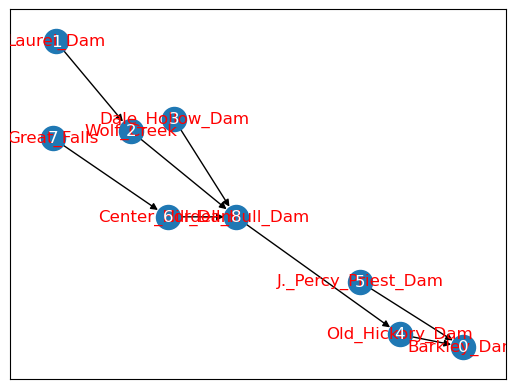

In [39]:
pos = nx.drawing.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [40]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

In [41]:
start_date = "2019-01-01"
end_date = "2019-12-31"
subset = subset.sel(time=slice(start_date, end_date))

dims = ['run_type', 'station', 'flow_type']
stat_vars = ['pearson-r', 'pearson-r p-val', 'nse', 'nse1', 'rmse', 'norm_rmse', 'mae', 'norm_mae', 'kge']

results_stats_data = {k: [] for k in dims + stat_vars} # make dictionary to store results

for node in G.nodes:
    station = G.nodes[node]['name']

    # f, ax = plt.subplots(figsize=(12, 6))

    reg_inflow = (subset['regulated_inflow'].sel(node=node) * 1e-6)
    nat_inflow = (subset['natural_inflow'].sel(node=node) * 1e-6)
    obs_inflow = (subset['obs_inflow'].sel(node=node) * 1e-6)

    no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
        reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['regulated_inflow'].data)
    
    no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
        nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['natural_inflow'].data)

    # store results for regulated flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('regulated')
    for var in stat_vars:
        results_stats_data[var].append(reg_inflow_stats[var])

    # store results for natural flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('natural')
    for var in stat_vars:
        results_stats_data[var].append(nat_inflow_stats[var])

    # reg_inflow.plot(ax=ax, label=f'Regulated inflow (Mn. m3/day), r:{reg_inflow_stats["pearson-r"]:.2f}, kge:{reg_inflow_stats["kge"]:.4f}, norm_rmse:{reg_inflow_stats["norm_rmse"]:.4f}')
    # nat_inflow.plot(ax=ax, label=f'Natural inflow (from VIC) (Mn. m3/day), r:{nat_inflow_stats["pearson-r"]:.2f}, kge:{nat_inflow_stats["kge"]:.4f}, norm_rmse:{nat_inflow_stats["norm_rmse"]:.4f}', linestyle='dotted')
    # obs_inflow.plot(ax=ax, label=f'Observed inflow (Mn. m3/day)')
    # ax.set_title(f'Station/reservoir: {G.nodes[node]["name"]}. {len(list(G.predecessors(node)))} Upstream dams')
    # ax.set_ylabel("Inflow (Million m3/day)")
    # ax.legend()

    # save_dir = Path("../../results/04_era5")
    # save_dir.mkdir(exist_ok=True)
    # save_fn = save_dir / f"{node:0>2}_{G.nodes[node]['name']}.png"
    # plt.savefig(save_fn)

{'pearson-r': 0.7377914306192904, 'pearson-r p-val': 3.2048174765799557e-56, 'nse': 0.247380888458143, 'nse1': 0.17868624813287703, 'rmse': 91.41397913607972, 'norm_rmse': 0.1652497218995532, 'mae': 66.66116782607449, 'norm_mae': 0.12050388298227471, 'kge': 0.48294701650118}
{'pearson-r': 0.7516064543715286, 'pearson-r p-val': 2.0280263747843483e-59, 'nse': -5.8966439692840735, 'nse1': -0.42765395535950446, 'rmse': 276.72213249626714, 'norm_rmse': 0.5002326325866194, 'mae': 115.8742072678408, 'norm_mae': 0.2094666560552814, 'kge': -1.2951271901278716}
{'pearson-r': 0.6032893966262206, 'pearson-r p-val': 4.1855241287169525e-33, 'nse': -3.041244315857991, 'nse1': -0.3866041898604722, 'rmse': 5.609516870134033, 'norm_rmse': 0.2924126422078776, 'mae': 2.353777829405726, 'norm_mae': 0.1226976244480758, 'kge': -0.8188564636251978}
{'pearson-r': 0.6032893966262206, 'pearson-r p-val': 4.1855241287169525e-33, 'nse': -3.041244315857991, 'nse1': -0.3866041898604722, 'rmse': 5.609516870134033, 'no

In [42]:
# convert results into dataset
resds = pd.DataFrame(results_stats_data).set_index(dims).to_xarray()

# add attributes
resds['pearson-r'].attrs = {'long_name': 'Pearson correlation coefficient', 'min': -1, 'max': 1, 'unit': '1'}
resds['pearson-r p-val'].attrs = {'long_name': 'Pearson correlation coefficient p-value', 'min': 0, 'max': 1, 'unit': '1'}
resds['nse'].attrs = {'long_name': 'Nash-Sutcliffe efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['nse1'].attrs = {'long_name': 'Nash-Sutcliffe efficiency (NSE1)', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['rmse'].attrs = {'long_name': 'Root mean squared error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_rmse'].attrs = {'long_name': 'Normalized root mean squared error', 'min': 0, 'max': 1, 'unit': '1'}
resds['mae'].attrs = {'long_name': 'Mean absolute error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_mae'].attrs = {'long_name': 'Normalized mean absolute error', 'min': 0, 'max': 1, 'unit': '1'}
resds['kge'].attrs = {'long_name': 'Kling-Gupta efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}

# add coordinate attributes
resds.coords['run_type'].attrs = {'long_name': 'Run type', 'description': 'Type of run to compare between different model runs. For example: `ERA5`, `IMERG-Late`, `IMERG-Final` etc. denoting which type of precipitation product used.'}
resds.coords['station'].attrs = {'long_name': 'Station/reservoir name', 'description': 'Name of station/reservoir'}
resds.coords['flow_type'].attrs = {'long_name': 'Flow type', 'description': 'Regulated or Natural flow'}

# add dataset attributes
resds.attrs = {
    'description': 'Statistics for inflow at each station/reservoir for the specifed time period.', 
    'date_created': str(datetime.datetime.now())
}

try:
    START_DATE = str(subset['time'].min().values)
    END_DATE = str(subset['time'].max().values)
    resds.attrs['from_date'] = START_DATE
    resds.attrs['to_date'] = END_DATE
except:
    pass

resds

<xarray.Dataset>
Dimensions:          (run_type: 1, station: 9, flow_type: 2)
Coordinates:
  * run_type         (run_type) object 'IMERG-Late'
  * station          (station) object 'Barkley_Dam' ... 'Wolf_Creek'
  * flow_type        (flow_type) object 'natural' 'regulated'
Data variables:
    pearson-r        (run_type, station, flow_type) float64 0.7516 ... 0.6555
    pearson-r p-val  (run_type, station, flow_type) float64 2.028e-59 ... 1.1...
    nse              (run_type, station, flow_type) float64 -5.897 ... -2.082
    nse1             (run_type, station, flow_type) float64 -0.4277 ... -0.2313
    rmse             (run_type, station, flow_type) float64 276.7 ... 97.36
    norm_rmse        (run_type, station, flow_type) float64 0.5002 ... 0.2448
    mae              (run_type, station, flow_type) float64 115.9 ... 42.78
    norm_mae         (run_type, station, flow_type) float64 0.2095 ... 0.1075
    kge              (run_type, station, flow_type) float64 -1.295 ... -0.5315
Attributes:
    description:   Statistics for inflow at each station/reservoir for the sp...
    date_created:  2023-08-22 15:00:16.266076
    from_date:     2019-01-01T00:00:00.000000000
    to_date:       2019-12-31T00:00:00.000000000

In [43]:
# save resulting statistics 
save_dir = Path("../../results/rr_stats")
save_dir.mkdir(exist_ok=True, parents=True)
# nc
save_fp = save_dir / f"{str(RUN_TYPE)}.nc"
resds.to_netcdf(save_fp)
# csv
save_fp = save_dir / f"{str(RUN_TYPE)}.csv"
resds.to_dataframe().to_csv(save_fp)